In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
imdb = load_dataset("imdb")

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        logits = self.linear(x)
        probs = torch.sigmoid(logits)
        return probs

In [3]:
def train_one_subset(train_texts, train_labels, val_texts, val_labels, test_texts, test_labels, 
                     max_features=5000, num_epochs=5, batch_size=32):
    train_loss_list = []
    val_loss_list = []

    tfidf = TfidfVectorizer(max_features=max_features, 
                            lowercase=True, token_pattern=r'\w+')
    X_train_tfidf = tfidf.fit_transform(train_texts)
    X_val_tfidf   = tfidf.transform(val_texts)
    X_test_tfidf = tfidf.transform(test_texts)
    
    train_dataset = IMDBTfidfDataset(X_train_tfidf, train_labels)
    val_dataset   = IMDBTfidfDataset(X_val_tfidf, val_labels)
    test_dataset = IMDBTfidfDataset(X_test_tfidf, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    input_dim = X_train_tfidf.shape[1]
    model = LogisticRegressionModel(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=5e-3)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_samples = 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            preds = model(batch_x).squeeze(1)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_x.size(0)
            total_samples += batch_x.size(0)

        avg_loss = total_loss / total_samples
        train_loss_list.append(avg_loss)
        #print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")
        
        model.eval()
        total_val_loss = 0
        total_val_samp = 0
        with torch.no_grad():
            for batch_x_val, batch_y_val in val_loader:
                preds_val = model(batch_x_val).squeeze(1)
                loss_val  = criterion(preds_val, batch_y_val)
                total_val_loss += loss_val.item() * batch_x_val.size(0)
                total_val_samp += batch_x_val.size(0)
        avg_val_loss = total_val_loss / total_val_samp
        val_loss_list.append(avg_val_loss)
        
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            preds = model(batch_x).squeeze(1)
            predicted = (preds >= 0.5).float()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    p = precision_score(all_labels, all_preds)
    r = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    return accuracy, p, r, f1, train_loss_list, val_loss_list, tfidf, model

In [4]:
import torch
from torch.utils.data import Dataset

class IMDBTfidfDataset(Dataset):
    def __init__(self, X_tfidf, labels):
        self.X = X_tfidf
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # 将 sparse row -> dense
        row = self.X[idx].toarray().squeeze()
        x_tensor = torch.tensor(row, dtype=torch.float32)
        y_tensor = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x_tensor, y_tensor

In [5]:
shuffled_test = imdb["test"].shuffle(seed=42)
test_texts = shuffled_test["text"][:2000]
test_labels = shuffled_test["label"][:2000]

In [6]:
shuffled_train = imdb["train"].shuffle(seed=45)

val_size = 2000
train_size = 25000 - val_size

train_subset = shuffled_train.select(range(train_size))
val_subset   = shuffled_train.select(range(train_size, 25000))

train_texts_all = train_subset["text"]
train_labels_all = train_subset["label"]

val_texts_all = val_subset["text"]
val_labels_all = val_subset["label"]

subset_sizes = [1000, 5000, 10000, 25000]
results = []
train_loss_dict = {}
val_loss_dict = {}

In [7]:
for size in subset_sizes:

    subset_texts = train_texts_all[:size]
    subset_labels = train_labels_all[:size]

    acc, p, r, f1, train_loss_list, val_loss_list, tfidf, model = train_one_subset(
        train_texts=subset_texts, 
        train_labels=subset_labels,
        val_texts=val_texts_all,
        val_labels=val_labels_all,
        test_texts=test_texts, 
        test_labels=test_labels,
        max_features=5000,
        num_epochs=10,
        batch_size=32
    )

    results.append({
        "TrainSize": size,
        "Accuracy": acc,
        "Precision": p,
        "Recall": r,
        "F1": f1
    })
    train_loss_dict[size] = train_loss_list
    val_loss_dict[size] = val_loss_list
    
    weights = model.linear.weight.detach().cpu().numpy().squeeze()
    feature_names = tfidf.get_feature_names_out()
    topk = 10
    top_idx = np.argsort(np.abs(weights))[-topk:]
    print(f"\nTop {topk} influential features for TrainSize={size}:")
    for idx in reversed(top_idx):
        print(f"  {feature_names[idx]:<15}  {weights[idx]:+.4f}")
        
    misclassified = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for text, true_label in zip(test_texts, test_labels):
            x_vec = tfidf.transform([text])
            x_tensor = torch.tensor(x_vec.toarray(), dtype=torch.float32)
            prob = model(x_tensor).item()
            pred = 1 if prob >= 0.5 else 0
            if pred != true_label and len(misclassified) < 5:
                misclassified.append((text, true_label, pred, prob))

    with open(f"misclassified_size{size}.txt", "w", encoding="utf-8") as fout:
        for txt, true, pred, prob in misclassified:
            fout.write(f"True={true}, Pred={pred}, Prob={prob:.3f}\n{txt}\n\n")


Top 10 influential features for TrainSize=1000:
  worst            -1.0716
  great            +1.0707
  waste            -1.0600
  no               -1.0397
  awful            -1.0185
  wonderful        +0.9876
  bad              -0.9263
  worse            -0.9078
  fantastic        +0.9071
  unfortunately    -0.8864

Top 10 influential features for TrainSize=5000:
  worst            -4.0069
  awful            -3.6973
  waste            -3.5945
  bad              -3.4167
  boring           -3.3976
  great            +3.3640
  perfect          +3.1503
  excellent        +3.0767
  favorite         +3.0563
  terrible         -3.0450

Top 10 influential features for TrainSize=10000:
  worst            -6.8470
  awful            -5.9915
  waste            -5.7741
  boring           -5.2192
  bad              -5.1537
  great            +4.9912
  dull             -4.9538
  excellent        +4.9219
  amazing          +4.7436
  badly            -4.6316

Top 10 influential features for TrainSize

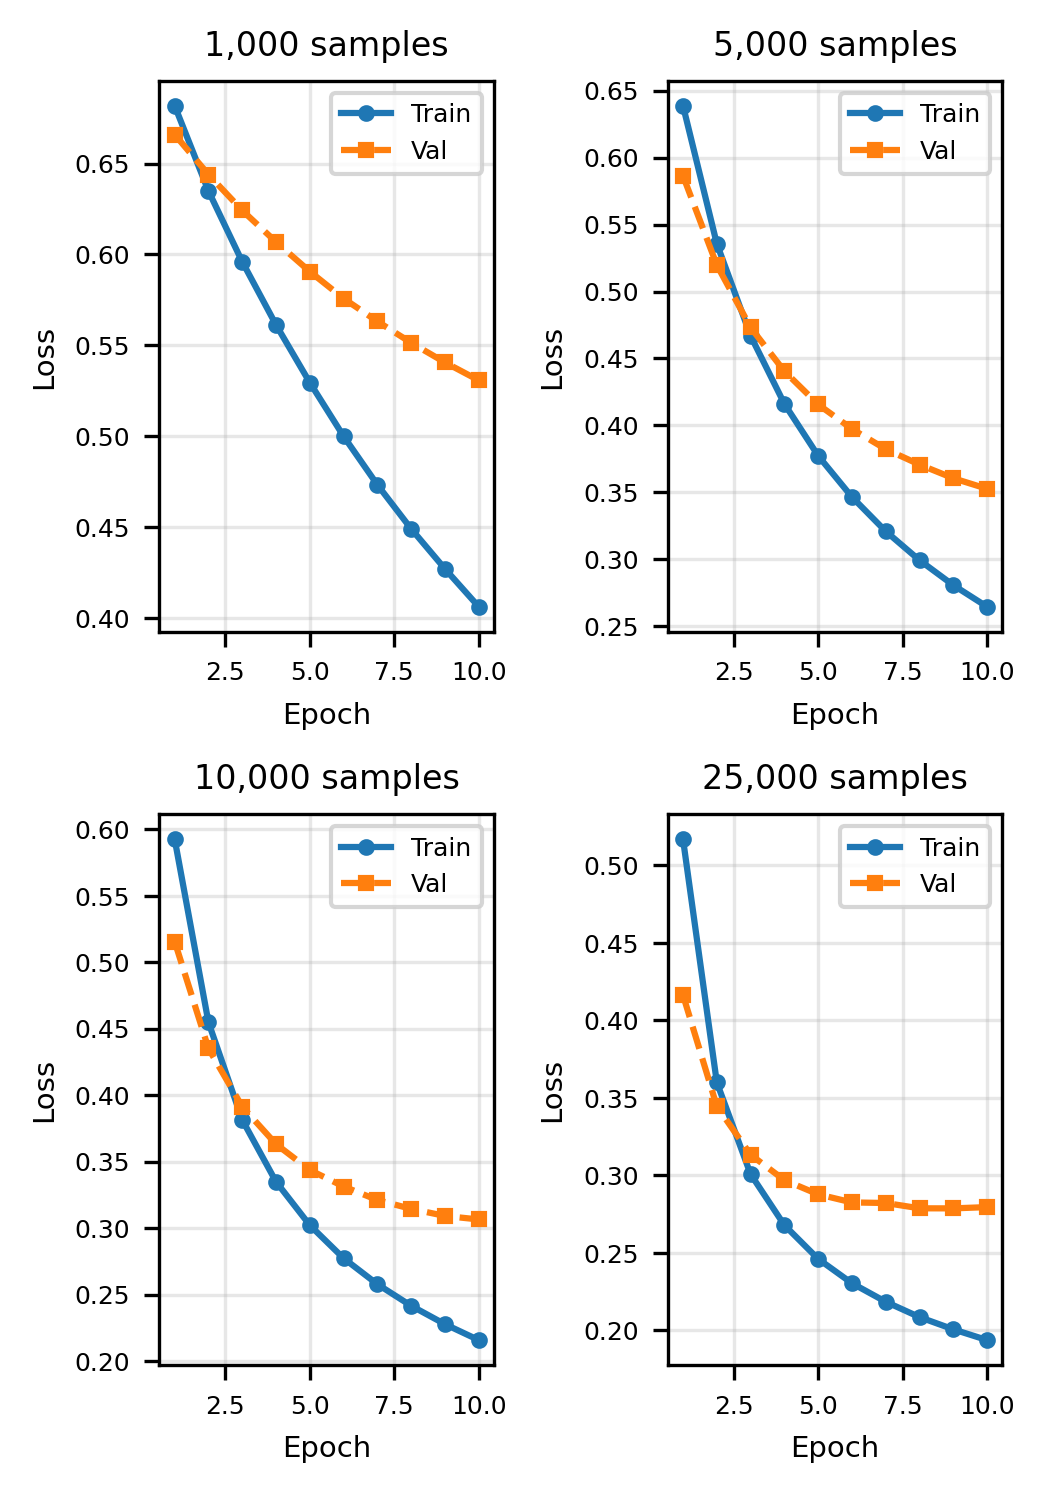

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2,
                         figsize=(3.5, 5.0),
                         dpi=300)
axes = axes.ravel()

for ax, size in zip(axes, subset_sizes):
    train_losses = train_loss_dict[size]
    val_losses   = val_loss_dict[size]
    epochs = range(1, len(train_losses)+1)

    ax.plot(epochs, train_losses, label='Train', marker='o', markersize=3)
    ax.plot(epochs, val_losses,  label='Val',   marker='s', markersize=3,
            linestyle='--')
    ax.set_title(f'{size:,} samples', fontsize=8)
    ax.set_xlabel('Epoch', fontsize=7)
    ax.set_ylabel('Loss',  fontsize=7)
    ax.tick_params(labelsize=6)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=6, loc='best')

plt.tight_layout(pad=0.8)
plt.savefig('loss_curves_grid.pdf',
            bbox_inches='tight')
plt.show()

In [9]:
import pandas as pd

df_results = pd.DataFrame(results)
print(df_results)

   TrainSize  Accuracy  Precision  Recall        F1
0       1000    0.8205   0.809662   0.838  0.823587
1       5000    0.8670   0.869960   0.863  0.866466
2      10000    0.8840   0.873541   0.898  0.885602
3      25000    0.8825   0.889908   0.873  0.881373


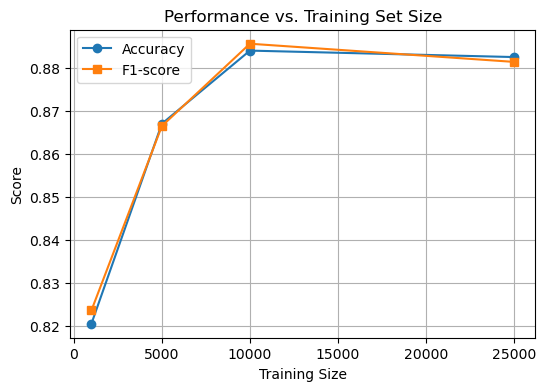

In [10]:
plt.figure(figsize=(6, 4))

plt.plot(df_results["TrainSize"], df_results["Accuracy"], marker='o', label='Accuracy')
plt.plot(df_results["TrainSize"], df_results["F1"], marker='s', label='F1-score')

plt.title("Performance vs. Training Set Size")
plt.xlabel("Training Size")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.savefig("perf_vs_size.pdf", bbox_inches="tight")
plt.show()